In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import scipy.stats as stats
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA

from IPython.display import Image

%matplotlib inline

In [32]:
data = pd.read_excel(r'C:\Users\raflg\Downloads\Databases\GPS_data.xls')
df = data.copy()

i = 1
for a in df.Athlete.unique():
    df.loc[df['Athlete']==a, 'Athlete'] = 'Player ' + str(i)
    i +=1

df

,Athlete,Unit,Group,Position,Date,Week,Type,Distance Total (m),m/min,High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),>85% Distance (m)
0,Player 1,Forward,Tight Forwards,Lock,2016-12-02,Week 1,Training,9386,79,1312,115,146,50,7,4,14,18
1,Player 2,Back,Midfield,2nd Five / Inside Centre,2016-12-02,Week 1,Training,6712,57,1184,83,71,46,0,0,0,0
2,Player 3,Back,Outside Backs,Wing,2016-12-02,Week 1,Training,9621,81,1429,110,145,57,23,2,0,2
3,Player 4,Forward,Tight Forwards,Lock,2016-12-02,Week 1,Training,8779,74,702,76,60,22,0,0,0,0
4,Player 5,Forward,Loose Forwards,Flanker,2016-12-02,Week 1,Training,798,74,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,Player 37,Back,Outside Backs,Wing,2017-07-29,Week 35,Game,1652,18,271,36,11,13,8,0,0,0
3840,Player 13,Forward,Loose Forwards,Flanker,2017-07-29,Week 35,Game,4627,52,368,101,21,17,0,0,0,0
3841,Player 14,Back,Inside Backs,Halfback,2017-07-29,Week 35,Game,1672,18,176,33,9,7,3,2,0,2
3842,Player 16,Forward,Tight Forwards,Prop,2017-07-29,Week 35,Game,4140,47,202,70,5,2,0,0,0,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3844 entries, 0 to 3843
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Athlete                   3844 non-null   object        
 1   Unit                      3844 non-null   object        
 2   Group                     3844 non-null   object        
 3   Position                  3844 non-null   object        
 4   Date                      3844 non-null   datetime64[ns]
 5   Week                      3844 non-null   object        
 6   Type                      3844 non-null   object        
 7   Distance Total (m)        3844 non-null   int64         
 8   m/min                     3844 non-null   int64         
 9   High Int Speed (m)        3844 non-null   int64         
 10  Sprints (m)               3844 non-null   int64         
 11  Hi Int Acceleration (nb)  3844 non-null   int64         
 12  Hi Int Deceleration 

**Changement de format de la colonne 'Week'**

**Création de sous df pour les entrainements et les matchs**

In [34]:
a = df.Date.dt.year.astype(str).str[-2:]
a = a.astype(int)*100
b = df.Date.dt.isocalendar().week.astype(int)
df['Week'] = a + b

df.loc[df['Date']=='2017-01-01', 'Week'] = 1652

i = 1
for w in df.Week.unique():
    df.loc[df['Week']==w, 'Week'] = i
    i +=1

df.Week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [35]:
df_training = df[df['Type']=='Training'].copy()
df_game = df[df['Type']=='Game'].copy()

df_training.Week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

**Compte du nombre de saisies/ports du GPS par semaine et par joueur**

In [36]:
pd.crosstab(df_training.Athlete, df_training.Week)
#Il y a un décalage des semaines car la df originale n'a aucune données sur les deux semaines de coupure à Noël
#Le problème sera réglé plus tard

Week,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
Athlete,,,,,,,,,,,,,,,,,,,,,
Player 1,1,4,4,3,6,6,4,4,8,3,...,2,2,1,0,3,3,3,5,4,5
Player 10,1,4,3,3,6,2,4,6,9,5,...,3,4,2,4,4,3,3,4,4,5
Player 11,1,2,4,3,6,6,4,4,7,3,...,1,0,0,0,3,0,0,1,2,2
Player 12,1,4,4,3,6,6,4,4,9,3,...,2,2,2,2,4,3,3,4,3,5
Player 13,1,4,4,0,5,6,2,4,9,3,...,2,3,2,2,5,3,3,5,4,5
Player 14,1,2,3,3,6,6,5,6,1,2,...,2,3,2,4,4,2,3,4,4,5
Player 15,1,4,4,0,4,5,4,4,6,4,...,0,0,0,0,0,0,0,0,0,0
Player 16,1,2,3,3,5,6,1,4,5,3,...,2,3,1,2,5,3,3,3,4,5
Player 17,1,4,4,3,6,5,5,4,0,2,...,0,0,1,2,2,1,1,0,0,0


In [37]:
marqueurs = ['Distance Total (m)', 'm/min', 'High Int Speed (m)', 'Sprints (m)', 'Hi Int Acceleration (nb)', 
             'Hi Int Deceleration (nb)', '80% Distance Hi Int (m)', '85% Distance Hi Int (m)', '90% Distance Hi Int (m)', 
             '>85% Distance (m)']

athletes = df.Athlete.unique()

df.columns

Index(['Athlete', 'Unit', 'Group', 'Position', 'Date', 'Week', 'Type',
       'Distance Total (m)', 'm/min', 'High Int Speed (m)', 'Sprints (m)',
       'Hi Int Acceleration (nb)', 'Hi Int Deceleration (nb)',
       '80% Distance Hi Int (m)', '85% Distance Hi Int (m)',
       '90% Distance Hi Int (m)', '>85% Distance (m)'],
      dtype='object')

**Création du tableau descriptif**

In [38]:
df_arranged = df.melt(id_vars=['Athlete', 'Unit', 'Group', 'Position', 'Date', 'Week', 'Type'], 
                      var_name='Marqueurs', value_name='Value')
df_arranged

,Athlete,Unit,Group,Position,Date,Week,Type,Marqueurs,Value
0,Player 1,Forward,Tight Forwards,Lock,2016-12-02,1,Training,Distance Total (m),9386
1,Player 2,Back,Midfield,2nd Five / Inside Centre,2016-12-02,1,Training,Distance Total (m),6712
2,Player 3,Back,Outside Backs,Wing,2016-12-02,1,Training,Distance Total (m),9621
3,Player 4,Forward,Tight Forwards,Lock,2016-12-02,1,Training,Distance Total (m),8779
4,Player 5,Forward,Loose Forwards,Flanker,2016-12-02,1,Training,Distance Total (m),798
...,...,...,...,...,...,...,...,...,...
38435,Player 37,Back,Outside Backs,Wing,2017-07-29,33,Game,>85% Distance (m),0
38436,Player 13,Forward,Loose Forwards,Flanker,2017-07-29,33,Game,>85% Distance (m),0
38437,Player 14,Back,Inside Backs,Halfback,2017-07-29,33,Game,>85% Distance (m),2
38438,Player 16,Forward,Tight Forwards,Prop,2017-07-29,33,Game,>85% Distance (m),0


In [39]:
def d10(x):
    return x.quantile(0.1)

def d20(x):
    return x.quantile(0.2)

def d30(x):
    return x.quantile(0.3)

def d40(x):
    return x.quantile(0.4)

def d50(x):
    return x.quantile(0.5)

def d60(x):
    return x.quantile(0.6)

def d70(x):
    return x.quantile(0.7)

def d80(x):
    return x.quantile(0.8)

def d90(x):
    return x.quantile(0.9)

agg_func_desc = {'Value':['min', 'max', 'median', d10, d20, d30, d40, d50, d60, d70, d80, d90]}
    
df_descriptive = df_arranged.groupby(['Week', 'Marqueurs', 'Type']).agg(agg_func_desc)

In [40]:
#Regardons la semaine 13
df_descriptive.loc[13]

Value                                        \
                                    min   max  median     d10     d20     d30   
Marqueurs                Type                                                   
80% Distance Hi Int (m)  Game         0    31     0.0     0.0     0.0     0.0   
                         Training     0    60     0.0     0.0     0.0     0.0   
85% Distance Hi Int (m)  Game         0    30     0.0     0.0     0.0     0.0   
                         Training     0    38     0.0     0.0     0.0     0.0   
90% Distance Hi Int (m)  Game         0     9     0.0     0.0     0.0     0.0   
                         Training     0    41     0.0     0.0     0.0     0.0   
>85% Distance (m)        Game         0    35     0.0     0.0     0.0     0.0   
                         Training     0    74     0.0     0.0     0.0     0.0   
Distance Total (m)       Game      1146  6752  3264.0  1513.9  2002.4  2385.9   
                         Training  1012  7187  4018.0  2046.6  2880.0  3256.7   
Hi Int Acceleration (nb) Game         0    56    20.5     3.4     4.0     7.1   
                         Training     1    68    20.0     5.0     9.0    13.0   
Hi Int Deceleration (nb) Game         0    51    19.0     1.7     4.4     7.3   
                         Training     1    56    16.0     4.0     6.0     9.0   
High Int Speed (m)       Game        23  1078   297.0    53.7   114.4   145.5   
                         Training    10  1114   245.5    77.1   121.0   142.0   
Sprints (m)              Game        16   174    83.0    24.4    33.4    52.0   
                         Training    19   163    78.0    37.7    51.8    63.0   
m/min                    Game        31    92    57.0    36.1    48.6    52.2   
                         Training    20   122    45.0    34.0    36.0    39.0   

                                                                           \
                                      d40     d50     d60     d70     d80   
Marqueurs                Type                                               
80% Distance Hi Int (m)  Game         0.0     0.0     2.0     4.9    10.8   
                         Training     0.0     0.0     0.2     4.0     9.0   
85% Distance Hi Int (m)  Game         0.0     0.0     0.0     0.0     2.6   
                         Training     0.0     0.0     0.0     0.0     2.0   
90% Distance Hi Int (m)  Game         0.0     0.0     0.0     0.0     0.0   
                         Training     0.0     0.0     0.0     0.0     0.0   
>85% Distance (m)        Game         0.0     0.0     0.0     0.0     2.6   
                         Training     0.0     0.0     0.0     0.0     2.0   
Distance Total (m)       Game      2666.2  3264.0  3796.2  4171.3  4788.8   
                         Training  3622.8  4018.0  4461.0  4798.5  5244.6   
Hi Int Acceleration (nb) Game        13.8    20.5    26.2    33.7    37.6   
                         Training    15.8    20.0    24.0    29.0    32.6   
Hi Int Deceleration (nb) Game        14.8    19.0    26.0    27.0    29.2   
                         Training    12.0    16.0    18.2    21.9    28.6   
High Int Speed (m)       Game       240.4   297.0   424.2   502.3   550.4   
                         Training   181.0   245.5   330.4   422.3   527.2   
Sprints (m)              Game        74.4    83.0    86.6   100.5   120.0   
                         Training    70.0    78.0    91.4   102.8   117.0   
m/min                    Game        56.0    57.0    62.2    64.8    71.2   
                         Training    41.8    45.0    48.0    50.0    53.6   

                                           
                                      d90  
Marqueurs                Type              
80% Distance Hi Int (m)  Game        14.5  
                         Training    20.3  
85% Distance Hi Int (m)  Game         6.6  
                         Training    17.2  
90% Distance Hi Int (m)  Game         0.3  
                         Training     2.3  
>8

**Création d'une df avec toutes les dates depuis la min jusqu'à la max pour chaque joueur**

In [41]:
list_dfs = []

for A in df.Athlete.unique():
    dff = df[df['Athlete'] == A].copy()
    
    a = pd.DataFrame(data={'Date': pd.date_range(dff.Date.min(), dff.Date.max())})
    b = pd.merge(dff, a, how='outer', on='Date').sort_values(by='Date').reset_index().drop(columns='index')
    [b[col].fillna(0, inplace=True) for col in marqueurs]
    b['Type'].fillna('Rest', inplace=True)
    b['Athlete'].fillna(A, inplace=True)
    b['Unit'].fillna(method='pad', inplace=True)
    b['Group'].fillna(method='pad', inplace=True)
    b['Position'].fillna(method='pad', inplace=True)
    w_y = b.Date.dt.year.astype(str).str[-2:]
    w_y = w_y.astype(int)*100
    w_w = b.Date.dt.isocalendar().week.astype(int)
    b['Week'] = w_y + w_w
    
    list_dfs.append(b)

df_final = pd.concat(list_dfs)

df_final.loc[df_final['Date']=='2017-01-01', 'Week'] = 1652

i = 1
for w in df_final.Week.unique():
    df_final.loc[df_final['Week']==w, 'Week'] = i
    i +=1

**Arrangement de la df pour que les jours à plusieurs entrainements soient cumulés sur une ligne**

In [42]:
agg_func = {}
for m in marqueurs:
    agg_func[m] = 'sum'
    
df_plot = df_final.groupby(['Date', 'Athlete', 'Type', 'Week'], as_index=False).agg(agg_func)

#Vérification s'il n'y a pas des saisies doubles (surtout le jour de match)
#df_plot.loc[df_plot[['Athlete','Date']].duplicated(keep=False)]
df_plot

,Date,Athlete,Type,Week,Distance Total (m),m/min,High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),>85% Distance (m)
0,2016-12-02,Player 1,Training,1,9386.0,79.0,1312.0,115.0,146.0,50.0,7.0,4.0,14.0,18.0
1,2016-12-02,Player 10,Training,1,9430.0,80.0,1410.0,117.0,156.0,50.0,0.0,0.0,0.0,0.0
2,2016-12-02,Player 11,Training,1,9989.0,84.0,1914.0,143.0,137.0,61.0,8.0,12.0,6.0,18.0
3,2016-12-02,Player 12,Training,1,10169.0,86.0,1566.0,134.0,147.0,61.0,0.0,0.0,0.0,0.0
4,2016-12-02,Player 13,Training,1,9780.0,83.0,1311.0,109.0,119.0,38.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158,2017-07-29,Player 36,Game,35,5432.0,61.0,522.0,110.0,33.0,32.0,33.0,11.0,19.0,30.0
8159,2017-07-29,Player 37,Game,35,1652.0,18.0,271.0,36.0,11.0,13.0,8.0,0.0,0.0,0.0
8160,2017-07-29,Player 5,Game,35,2785.0,31.0,359.0,59.0,16.0,18.0,0.0,0.0,0.0,0.0
8161,2017-07-29,Player 8,Game,35,5150.0,58.0,429.0,105.0,18.0,20.0,12.0,2.0,0.0,2.0


**Création d'une df pour les matchs**

In [43]:
dfs_game = []

for A in df.Athlete.unique():
    dfp = df_plot[df_plot['Athlete']==A].copy()
    df_m = dfp[dfp['Type']=='Game'].copy()
    
    a = pd.DataFrame(data={'Date': pd.date_range(dfp.Date.min(), dfp.Date.max())})
    b = pd.merge(df_m, a, how='outer', on='Date').sort_values(by='Date').reset_index().drop(columns='index')
    [b[col].fillna(0, inplace=True) for col in marqueurs]
    b['Type'].fillna('Game', inplace=True)
    b['Athlete'].fillna(A, inplace=True)
    dfs_game.append(b)
    
df_plot_game = pd.concat(dfs_game)
df_plot_game

,Date,Athlete,Type,Week,Distance Total (m),m/min,High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),>85% Distance (m)
0,2016-12-02,Player 1,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-12-03,Player 1,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-12-04,Player 1,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-12-05,Player 1,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-12-06,Player 1,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2017-07-21,Player 40,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,2017-07-22,Player 40,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,2017-07-23,Player 40,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2017-07-24,Player 40,Game,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Création des colonnes pour les médiane et p75 ainsi que les médiane et p75 mobiles exponentielles**

In [70]:
for m in marqueurs:
    m_ext = m + '_tendanceM'
    df_plot[m_ext] = df_plot.groupby('Athlete')[m].transform(lambda x: x.rolling(window=7).quantile(.5).ewm(span=7).mean())
    
    q_ext = m+ '_tendanceP75'
    df_plot[m_ext] = df_plot.groupby('Athlete')[m].transform(lambda x: x.rolling(window=7).quantile(.75).ewm(span=7).mean())

    md_ext = m + '_median'
    df_plot[md_ext] = df_plot.groupby('Athlete')[m].transform('median')
    
    p_ext = m + '_p75'
    df_plot[p_ext] = df_plot.groupby('Athlete')[m].transform(lambda x: x.quantile(0.75))

In [71]:
tendance_list = ['tendanceM', 'tendanceP75']

**Création d'une df hebdomadaire**

In [74]:
agg_func_hebdo = {}
for m in marqueurs:
    agg_func_hebdo[m] = 'sum'
    agg_func_hebdo[m+'_tendanceM'] = 'median'
    agg_func_hebdo[m+'_tendanceP75'] = 'median'

df_hebdo = df_plot.groupby(['Week', 'Athlete'], as_index=False).agg(agg_func_hebdo)
df_hebdo

,Week,Athlete,Distance Total (m),Distance Total (m)_tendanceM,Distance Total (m)_tendanceP75,m/min,m/min_tendanceM,m/min_tendanceP75,High Int Speed (m),High Int Speed (m)_tendanceM,...,80% Distance Hi Int (m)_tendanceP75,85% Distance Hi Int (m),85% Distance Hi Int (m)_tendanceM,85% Distance Hi Int (m)_tendanceP75,90% Distance Hi Int (m),90% Distance Hi Int (m)_tendanceM,90% Distance Hi Int (m)_tendanceP75,>85% Distance (m),>85% Distance (m)_tendanceM,>85% Distance (m)_tendanceP75
0,1,Player 1,9386.0,NaN,NaN,79.0,NaN,NaN,1312.0,NaN,...,NaN,4.0,NaN,NaN,14.0,NaN,NaN,18.0,NaN,NaN
1,1,Player 10,9430.0,NaN,NaN,80.0,NaN,NaN,1410.0,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,1,Player 11,9989.0,NaN,NaN,84.0,NaN,NaN,1914.0,NaN,...,NaN,12.0,NaN,NaN,6.0,NaN,NaN,18.0,NaN,NaN
3,1,Player 12,10169.0,NaN,NaN,86.0,NaN,NaN,1566.0,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
4,1,Player 13,9780.0,NaN,NaN,83.0,NaN,NaN,1311.0,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,35,Player 5,20529.0,3584.125106,3584.125106,323.0,58.813179,58.813179,1910.0,251.062727,...,0.134654,6.0,3.187340e-03,3.187340e-03,0.0,6.726522e-08,6.726522e-08,6.0,3.187609e-03,3.187609e-03
1186,35,Player 6,7088.0,2622.704002,2622.704002,121.0,35.539548,35.539548,1096.0,155.381457,...,0.483473,48.0,5.497685e-03,5.497685e-03,24.0,2.328711e-07,2.328711e-07,72.0,5.498383e-03,5.498383e-03
1187,35,Player 7,8017.0,3346.360852,3346.360852,137.0,58.511902,58.511902,2014.0,325.903168,...,0.161700,15.0,3.036415e-02,3.036415e-02,4.0,5.828914e-07,5.828914e-07,19.0,3.036495e-02,3.036495e-02
1188,35,Player 8,23709.0,4660.336120,4660.336120,370.0,64.416726,64.416726,2380.0,437.701076,...,0.925539,9.0,2.024906e-08,2.024906e-08,0.0,1.108963e-13,1.108963e-13,9.0,2.024920e-08,2.024920e-08


**Création du graph**

In [75]:
joueurs_dp = widgets.Dropdown(description='Joueur :   ',
                           value=athletes[0],
                           options=athletes
                          )

marqueurs_dp = widgets.Dropdown(description='Marqueur :   ', 
                                value=marqueurs[0],
                                options=marqueurs
                               )

tendance_dp = widgets.Dropdown(description='Tendance :   ',
                               value=tendance_list[0],
                               options=tendance_list
                               )

trace1_q = go.Bar(x=df_plot.loc[df_plot['Athlete']==athletes[0], 'Date'],
                  y=df_plot.loc[df_plot['Athlete']==athletes[0], marqueurs[0]],
                  marker_color='#F6B047', name='Training', opacity=1)

trace2_q = go.Bar(x=df_plot_game.loc[(df_plot_game['Athlete']==athletes[0]),'Date'],
                  y=df_plot_game.loc[(df_plot_game['Athlete']==athletes[0]), marqueurs[0]],
                  marker_color='#576DF3', name='Game', opacity=1)

trace3_q = go.Scatter(x=df_plot.loc[df_plot['Athlete']==athletes[0], 'Date'],
                      y=df_plot.loc[df_plot['Athlete']==athletes[0], marqueurs[0]+'_'+tendance_list[0]],
                      mode='lines', name='Tendance', line=dict(width=1, shape='spline', smoothing=1.3), marker_color='#de2d26')

trace4_q = go.Scatter(x=df_plot.loc[df_plot['Athlete']==athletes[0],'Date'],
                      y=df_plot.loc[df_plot['Athlete']==athletes[0], marqueurs[0]+'_median'],
                      mode='lines', name='Median',
                      line=dict(width=0.7, color='black', dash='longdash'))

trace5_q = go.Scatter(x=df_plot.loc[df_plot['Athlete']==athletes[0],'Date'],
                      y=df_plot.loc[df_plot['Athlete']==athletes[0], marqueurs[0]+'_p75'],
                      mode='lines', name='p75',
                      line=dict(width=0.7, color='black', dash='dot'))

fig_q = go.FigureWidget(data=[trace1_q, trace2_q, trace3_q, trace4_q, trace5_q], layout=go.Layout(barmode='overlay'))

trace1_h = go.Bar(x=df_hebdo.loc[df_hebdo['Athlete']==athletes[0], 'Week'],
                  y=df_hebdo.loc[df_hebdo['Athlete']==athletes[0], marqueurs[0]],
                  marker_color='#F6B047', name='Médiane Sem.', opacity=1)

fig_h = go.FigureWidget(data=trace1_h)

def response(change):
    x1_1 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, 'Date']
    y1_1 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, marqueurs_dp.value]
    x1_2 = df_plot_game.loc[(df_plot_game['Athlete']==joueurs_dp.value),'Date']
    y1_2 = df_plot_game.loc[(df_plot_game['Athlete']==joueurs_dp.value), marqueurs_dp.value]
    x1_3 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, 'Date']
    y1_3 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, marqueurs_dp.value+'_'+tendance_dp.value]
    x1_4 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, 'Date']
    y1_4 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, marqueurs_dp.value+'_median']
    x1_5 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, 'Date']
    y1_5 = df_plot.loc[df_plot['Athlete']==joueurs_dp.value, marqueurs_dp.value+'_p75']
    
    x2_1 = df_hebdo.loc[df_hebdo['Athlete']==joueurs_dp.value, 'Week']
    y2_1 = df_hebdo.loc[df_hebdo['Athlete']==joueurs_dp.value, marqueurs_dp.value]
    
    with fig_q.batch_update():
        fig_q.data[0].x = x1_1
        fig_q.data[0].y = y1_1
        fig_q.data[1].x = x1_2
        fig_q.data[1].y = y1_2
        fig_q.data[2].x = x1_3
        fig_q.data[2].y = y1_3
        fig_q.data[3].x = x1_4
        fig_q.data[3].y = y1_4
        fig_q.data[4].x = x1_5
        fig_q.data[4].y = y1_5
        fig_q.layout.barmode = 'overlay'
    
    with fig_h.batch_update():
        fig_h.data[0].x = x2_1
        fig_h.data[0].y = y2_1

joueurs_dp.observe(response)
marqueurs_dp.observe(response)
tendance_dp.observe(response)

fig_q.update_layout(width=900, height=475,
                  template='plotly_white',
                  autosize=False)

fig_q.update_xaxes(tickangle=45, dtick='L1')

fig_q.update_layout(xaxis=dict(rangeselector=dict(buttons=
                                              list([dict(count=14, label='2s', step='day'),
                                                    dict(count=1, label='1m', step='month'),
                                                    dict(count=2, label='2m', step='month'),
                                                    dict(count=6, label='6m', step='month'),
                                                    dict(count=1, label='1a', step='year'),
                                                    dict(step='all')])
                                             ), rangeslider=dict( visible=True), type="date"))

fig_h.update_layout(width=900, height=350,
                  template='plotly_white',
                  autosize=False)

container = widgets.HBox([joueurs_dp, marqueurs_dp, tendance_dp])
widgets.VBox([container, fig_q, fig_h])

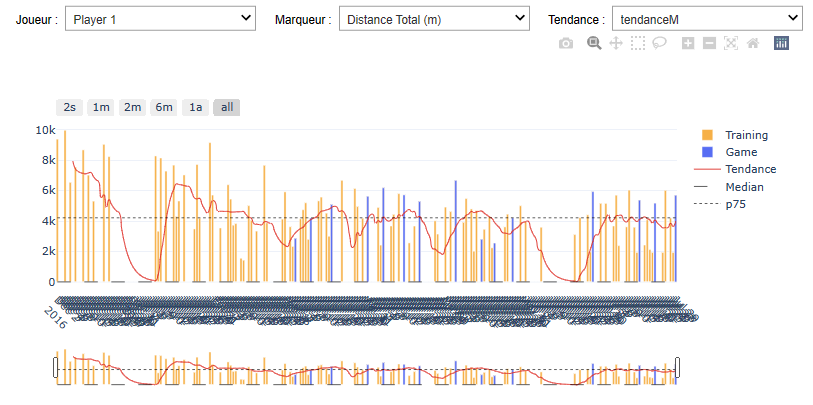

In [77]:
Image(filename='gps_capture1.PNG') 

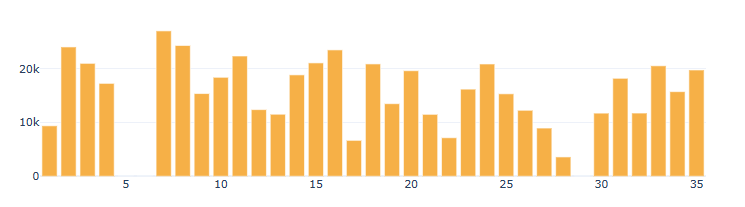

In [78]:
Image(filename='gps_capture2.PNG') 

**T-test**

In [79]:
df_ttest = df_plot.copy()
df_ttest = df_ttest.groupby(['Week', 'Athlete'], as_index=False).sum()
df_ttest.set_index('Athlete', inplace=True)
df_ttest

,Week,Distance Total (m),m/min,High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),...,Distance Total (m)_test_tendanceM,m/min_test_tendanceM,High Int Speed (m)_test_tendanceM,Sprints (m)_test_tendanceM,Hi Int Acceleration (nb)_test_tendanceM,Hi Int Deceleration (nb)_test_tendanceM,80% Distance Hi Int (m)_test_tendanceM,85% Distance Hi Int (m)_test_tendanceM,90% Distance Hi Int (m)_test_tendanceM,>85% Distance (m)_test_tendanceM
Athlete,,,,,,,,,,,,,,,,,,,,,
Player 1,1,9386.0,79.0,1312.0,115.0,146.0,50.0,7.0,4.0,14.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Player 10,1,9430.0,80.0,1410.0,117.0,156.0,50.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Player 11,1,9989.0,84.0,1914.0,143.0,137.0,61.0,8.0,12.0,6.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Player 12,1,10169.0,86.0,1566.0,134.0,147.0,61.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Player 13,1,9780.0,83.0,1311.0,109.0,119.0,38.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Player 5,35,20529.0,323.0,1910.0,425.0,118.0,90.0,29.0,6.0,0.0,...,15683.321498,259.911806,1137.801274,315.276610,54.310796,44.941822,3.390882e-03,0.000000e+00,0.000000e+00,0.000000e+00
Player 6,35,7088.0,121.0,1096.0,63.0,32.0,21.0,39.0,48.0,24.0,...,2294.317893,32.410957,110.377904,40.085587,4.903564,1.799416,1.835427e-04,0.000000e+00,0.000000e+00,0.000000e+00
Player 7,35,8017.0,137.0,2014.0,96.0,47.0,28.0,47.0,15.0,4.0,...,3384.515641,50.154090,61.890147,60.202372,6.418864,1.701678,4.609877e-19,0.000000e+00,0.000000e+00,0.000000e+00


In [80]:
ct = pd.crosstab(df_plot['Athlete'], df_plot['Week'])
ct.replace({0:np.nan}, inplace=True)
ct

Week,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
Athlete,,,,,,,,,,,,,,,,,,,,,
Player 1,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0
Player 10,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0
Player 11,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,3.0
Player 12,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0
Player 13,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0
Player 14,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0
Player 15,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Player 16,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0
Player 17,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,4.0,NaN,NaN,NaN


**Recherche des semaines avec au moins 50% des joueurs ayant des données/porter le GPS**

In [81]:
ct.dropna(axis=1, thresh=len(ct)*0.5, inplace=True)
print(ct.columns)

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35],
           dtype='int64', name='Week')


In [87]:
ttest_sem = [2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
             30, 31, 32, 33, 34, 35]

**Création d'un tableau pour le t-test**

In [88]:
test_tab = pd.DataFrame(columns=ttest_sem, index=marqueurs)

for sem in ttest_sem:
    for col in marqueurs:
        sample1 = df_ttest.loc[(df_ttest.Week == sem-1), col] 
        sample2 = df_ttest.loc[(df_ttest.Week == sem), col]
        
        test_data = {'Previous': sample1, 'Current': sample2}
        test_df = pd.concat(test_data, axis=1).dropna()
        
        stat1_, p_s1 = stats.normaltest(test_df['Previous'])
        stat2_, p_s2 = stats.normaltest(test_df['Current'])
        
        if (p_s1 > .05) and (p_s2 > .05):
            stat, p = stats.ttest_rel(test_df['Current'], test_df['Previous'])
            statg, pg = stats.ttest_rel(test_df['Current'], test_df['Previous'], alternative='greater')
            statl, pl = stats.ttest_rel(test_df['Current'], test_df['Previous'], alternative='less')
            if p > 0.05:
                sign = '='
            elif p < 0.05 and pg < 0.05:
                sign = '>'
            elif p <0.05 and pl < 0.05:
                sign = '<'
            test_tab.loc[col, sem] = sign
        else:
            stat, p = stats.wilcoxon(test_df['Current'], test_df['Previous'])
            statg, pg = stats.wilcoxon(test_df['Current'], test_df['Previous'], alternative='greater')
            statl, pl = stats.wilcoxon(test_df['Current'], test_df['Previous'], alternative='less')
            if p > 0.05:
                sign = '='
            elif p < 0.05 and pg < 0.05:
                sign = '>'
            elif p <0.05 and pl < 0.05:
                sign = '<'
            test_tab.loc[col, sem] = sign

C:\Users\raflg\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=17

C:\Users\raflg\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

C:\Users\raflg\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3351: UserWarning:

Sample size too small for normal approximation.



In [89]:
test_tab

,2,3,4,5,7,8,9,10,11,12,...,26,27,28,29,30,31,32,33,34,35
Distance Total (m),>,=,=,<,>,=,<,>,>,<,...,<,<,=,=,>,<,<,>,<,=
m/min,>,>,<,<,>,>,<,>,>,<,...,<,=,=,<,>,>,<,>,=,>
High Int Speed (m),>,=,=,<,>,=,<,>,>,<,...,<,=,=,=,>,<,>,=,=,>
Sprints (m),>,>,=,<,>,=,<,>,=,<,...,<,=,=,<,>,<,>,>,<,=
Hi Int Acceleration (nb),>,=,<,<,>,=,<,=,=,<,...,<,=,=,<,>,<,>,>,<,>
Hi Int Deceleration (nb),>,>,<,<,>,=,<,=,=,<,...,<,=,=,<,>,<,>,>,<,>
80% Distance Hi Int (m),>,>,<,<,>,>,<,=,<,=,...,=,=,<,<,>,=,=,<,=,>
85% Distance Hi Int (m),>,>,<,<,>,=,<,=,=,=,...,=,<,=,<,>,=,=,=,=,>
90% Distance Hi Int (m),=,>,=,<,>,>,=,=,=,<,...,=,<,=,<,>,<,=,=,<,=
>85% Distance (m),>,>,<,<,>,>,<,=,=,<,...,=,<,=,<,>,<,=,=,=,>


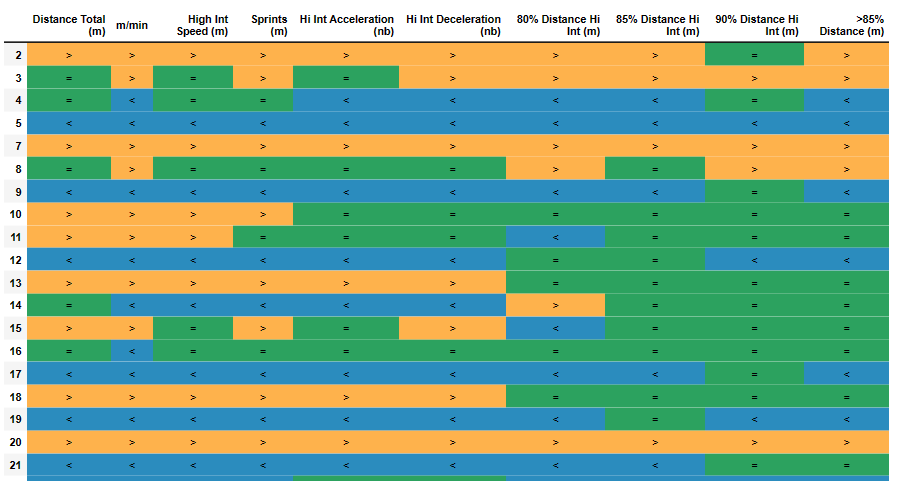

In [92]:
test_tab.T.style.set_properties(**{'text-align': 'center'}).\
applymap(lambda x: 'background-color : #2b8cbe' if x == '<' else ('background-color : #2ca25f' if x == '=' \
                                                                    else 'background-color : #feb24c'))
Image(filename='gps_capture3.PNG')

**Visualiser la somme de la distance totale de l'équipe pour chaque semaine**

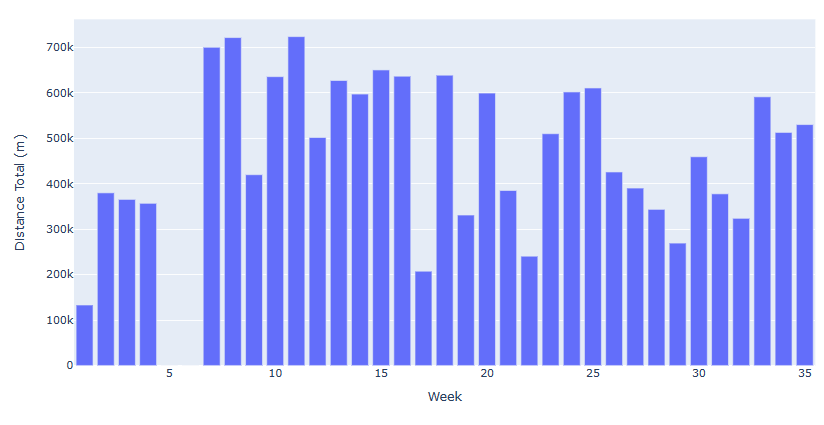

In [94]:
df_hebdo_total = df_plot.groupby(['Week']).agg(agg_func_hebdo)
df_hebdo_total.reset_index(inplace=True)

px.bar(df_hebdo_total, x='Week', y='Distance Total (m)')

Image(filename='gps_capture4.PNG')

**Visualisation du nombre de séances par semaine**

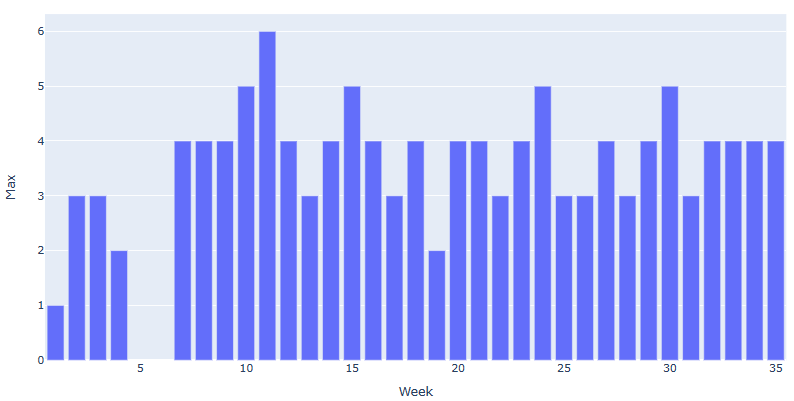

In [96]:
ct_bis = pd.crosstab(df_plot.loc[df_plot['Type']=='Training','Week'],
                  df_plot.loc[df_plot['Type']=='Training','Athlete'])

ct_bis['Max'] = ct_bis.max(axis=1)
ct_bis.reset_index(inplace=True)
px.bar(ct_bis, x='Week', y='Max')

Image(filename='gps_capture5.PNG')

**Clustering**

In [97]:
df_cluster = df.loc[(df['Week'] >= 7) & (df['Week'] <=11)].copy()
df_cluster.sort_values(by='Unit', inplace=True)
df_cluster = df_cluster.reset_index().drop(columns='index')

cluster_bck = df_cluster.loc[df_cluster['Unit']=='Back', marqueurs]
cluster_fwd = df_cluster.loc[df_cluster['Unit']=='Forward', marqueurs]

df_cluster

,Athlete,Unit,Group,Position,Date,Week,Type,Distance Total (m),m/min,High Int Speed (m),Sprints (m),Hi Int Acceleration (nb),Hi Int Deceleration (nb),80% Distance Hi Int (m),85% Distance Hi Int (m),90% Distance Hi Int (m),>85% Distance (m)
0,Player 27,Back,Outside Backs,Wing,2017-02-09,9,Training,4335,48,369,91,14,16,9,17,0,17
1,Player 10,Back,Outside Backs,Wing,2017-02-12,9,Training,1450,51,123,24,4,5,3,0,0,0
2,Player 10,Back,Outside Backs,Wing,2017-02-12,9,Training,914,32,115,14,4,3,0,0,0,0
3,Player 21,Back,Outside Backs,Wing,2017-02-12,9,Training,784,31,35,11,0,1,0,0,0,0
4,Player 21,Back,Outside Backs,Wing,2017-02-12,9,Training,1199,65,139,21,4,6,17,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,Player 1,Forward,Tight Forwards,Lock,2017-02-12,9,Training,1424,60,155,32,1,5,0,0,0,0
789,Player 22,Forward,Tight Forwards,Prop,2017-02-11,9,Training,1229,44,80,24,4,1,0,0,0,0
790,Player 22,Forward,Tight Forwards,Prop,2017-02-11,9,Training,1325,43,61,27,2,5,0,0,0,0
791,Player 22,Forward,Tight Forwards,Prop,2017-01-30,8,Training,2916,23,96,55,12,6,0,0,0,0


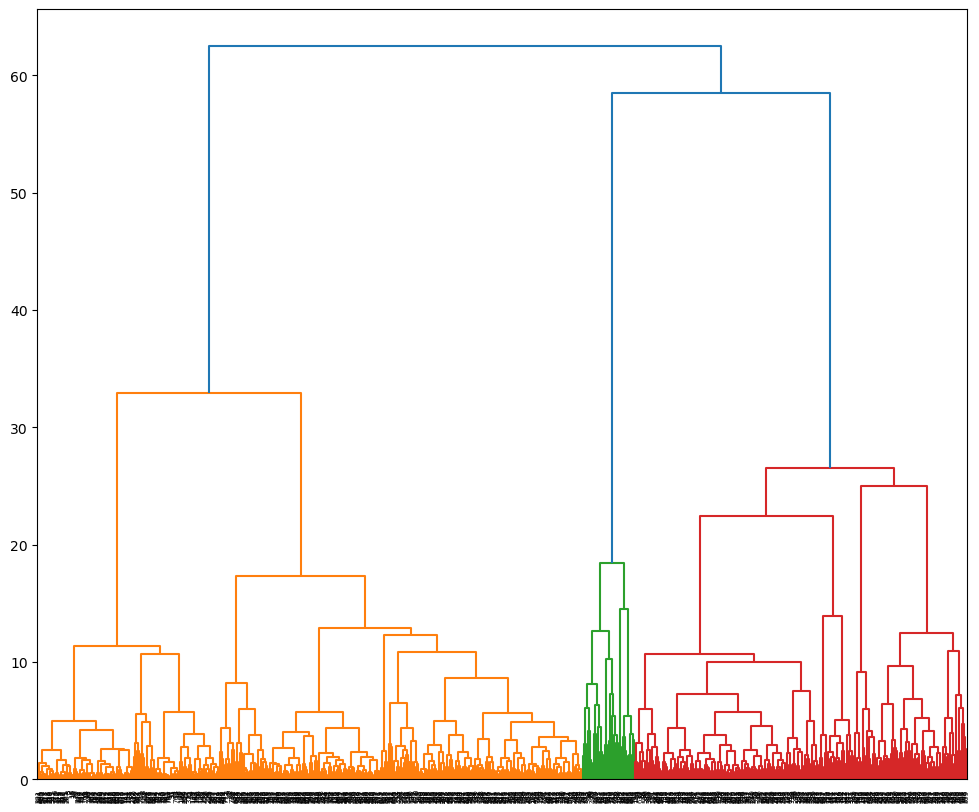

In [98]:
z_scaler = StandardScaler()

cluster_bck_z = z_scaler.fit_transform(cluster_bck)
cluster_fws_z = z_scaler.fit_transform(cluster_fwd)

df_cluster_z = pd.concat([pd.DataFrame(cluster_bck_z),pd.DataFrame(cluster_fws_z)]).reset_index().drop(columns='index')

hac_dend = linkage(df_cluster_z, method='ward', metric='euclidean')
plt.figure(figsize=(12,10))
dendrogram(hac_dend)
plt.show()

In [99]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(df_cluster_z)
labels = model.labels_

df_cluster['Cluster_Label'] = labels
df_cluster['Cluster_Label'].value_counts()

0    465
1    284
2     44
Name: Cluster_Label, dtype: int64

In [100]:
df_cluster['Total_Athlete'] = df_cluster.groupby('Athlete').Week.transform('count')

df_cluster['Cluster_1'] = df_cluster.groupby('Athlete')['Cluster_Label'].transform(lambda x: (x==0).sum())
df_cluster['Cluster_2'] = df_cluster.groupby('Athlete')['Cluster_Label'].transform(lambda x: (x==1).sum())
df_cluster['Cluster_3'] = df_cluster.groupby('Athlete')['Cluster_Label'].transform(lambda x: (x==2).sum())

df_cluster['% Cluster_1'] = ((df_cluster['Cluster_1'] / df_cluster['Total_Athlete']) * 100).round()
df_cluster['% Cluster_2'] = ((df_cluster['Cluster_2'] / df_cluster['Total_Athlete']) * 100).round()
df_cluster['% Cluster_3'] = ((df_cluster['Cluster_3'] / df_cluster['Total_Athlete']) * 100).round()

df_cluster_ct = df_cluster[['Athlete', '% Cluster_1', '% Cluster_2', '% Cluster_3', 'Cluster_Label']]

agg_func = {}

for c in df_cluster_ct.columns[1:]:
    if c != 'Cluster_Label':
        agg_func[c] = 'median'
    else:
        agg_func[c] = pd.Series.mode

df_cluster_recap = df_cluster_ct.groupby('Athlete').agg(agg_func)

df_cluster_recap['Cluster_Label'].replace({0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3'}, inplace=True)
df_cluster_recap.sort_values(by='Cluster_Label')

,% Cluster_1,% Cluster_2,% Cluster_3,Cluster_Label
Athlete,,,,
Player 1,50.0,36.0,14.0,Cluster 1
Player 7,59.0,31.0,10.0,Cluster 1
Player 6,82.0,18.0,0.0,Cluster 1
Player 4,67.0,27.0,7.0,Cluster 1
Player 35,57.0,33.0,10.0,Cluster 1
Player 34,60.0,40.0,0.0,Cluster 1
Player 32,86.0,14.0,0.0,Cluster 1
Player 30,50.0,40.0,10.0,Cluster 1
Player 3,55.0,35.0,10.0,Cluster 1


In [105]:
df_hac = df_cluster.merge(df_cluster_z, left_index=True, right_index=True)

rename_scaled = {}
i = 0
for m in marqueurs:
    rename_scaled[i] = m+'_z'
    i += 1

df_hac.rename(columns=rename_scaled, inplace=True)
df_hac['Cluster_Label'].replace({0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3'}, inplace=True)

df_recap_cluster = pd.DataFrame(columns=['Cluster 1', 'Cluster 2'], index=marqueurs)

for col in df_recap_cluster.columns:
    for m in marqueurs:
        diff = df_hac.loc[df_hac['Cluster_Label']==col, m].median() - df_hac[m].median()
        df_recap_cluster.loc[m,col] = np.round(diff,2)
        
df_recap_cluster.rename({'Cluster 1': 'Cluster 1 (diff)', 'Cluster 2': 'Cluster 2 (diff, médiane)'}, inplace=True)
df_recap_cluster

,Cluster 1,Cluster 2
Distance Total (m),-685.0,1034.0
m/min,-3.0,5.0
High Int Speed (m),-101.0,219.0
Sprints (m),-19.0,38.5
Hi Int Acceleration (nb),-7.0,15.0
Hi Int Deceleration (nb),-5.0,10.5
80% Distance Hi Int (m),0.0,3.0
85% Distance Hi Int (m),0.0,0.0
90% Distance Hi Int (m),0.0,0.0
>85% Distance (m),0.0,0.0


In [107]:
kmo_all, kmo_model = calculate_kmo(df_hac.iloc[:,7:17])
print('Overall KMO : {}'.format(kmo_model))
pd.DataFrame(index=marqueurs, data=kmo_all, columns=['KMO'])

Overall KMO : 0.6388615578281274


,KMO
Distance Total (m),0.714660
m/min,0.751734
High Int Speed (m),0.657790
Sprints (m),0.683108
Hi Int Acceleration (nb),0.773981
Hi Int Deceleration (nb),0.815415
80% Distance Hi Int (m),0.947202
85% Distance Hi Int (m),0.489929
90% Distance Hi Int (m),0.435351
>85% Distance (m),0.519782


In [108]:
marqueurs_z_pca = ['Distance Total (m)_z', 'm/min_z', 'High Int Speed (m)_z', 'Sprints (m)_z', 'Hi Int Acceleration (nb)_z',
                   'Hi Int Deceleration (nb)_z', '80% Distance Hi Int (m)_z', '>85% Distance (m)_z', '>85% Distance (m)_z']

df_pca_scaled = df_hac[marqueurs_z_pca]

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_pca_scaled)

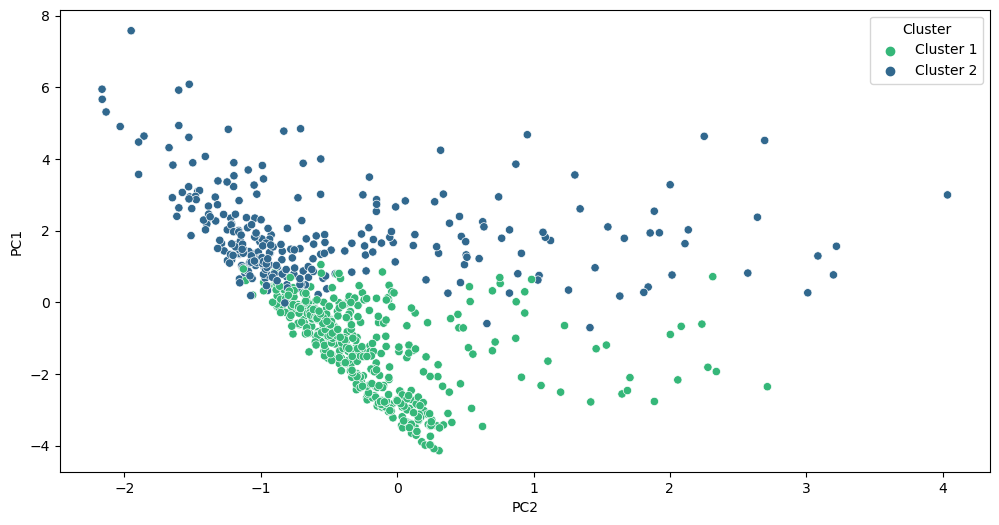

In [109]:
df_pca_plot = pd.DataFrame(df_pca, columns=['PC1','PC2'])
df_pca_plot['Cluster'] = labels
df_pca_plot['Cluster'].replace({0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3'}, inplace=True)
df_pca_plot.drop(df_pca_plot[df_pca_plot['Cluster'] == 'Cluster 3'].index, inplace=True)

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_pca_plot, x='PC2', y='PC1', hue='Cluster', palette='viridis_r')
plt.show()

**Visualisation des distributions des marqueurs selon cluster**

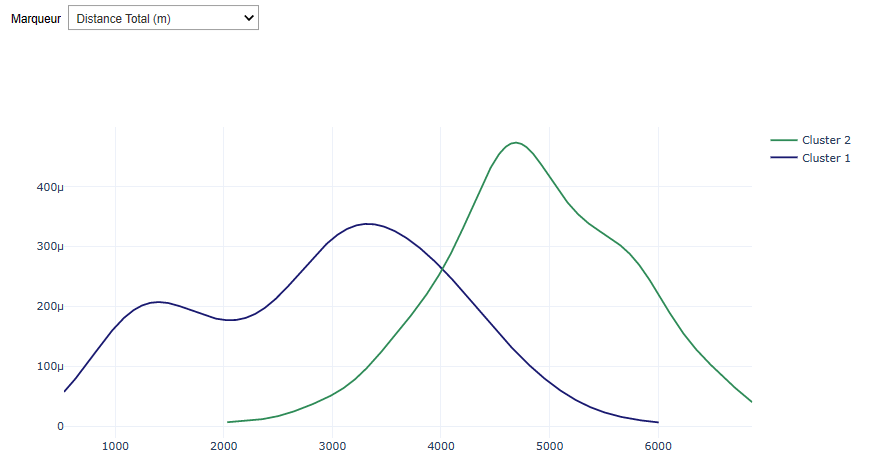

In [114]:
df_cluster_plot = df_hac[df_hac['Cluster_Label'] != 'Cluster 3']

def plot(Marqueur):
    fig = ff.create_distplot([df_cluster_plot.loc[df_cluster_plot['Cluster_Label']==c, Marqueur] for c in np.sort(df_cluster_plot['Cluster_Label'].unique())],
                             np.sort(df_cluster_plot['Cluster_Label'].unique()),
                             show_rug=False, bin_size=1, show_hist=False, colors=['#191970', '#2E8B57'])
    fig.update_layout(template='plotly_white')
    return fig

# widgets.interact(plot, Marqueur=marqueurs)

Image(filename='gps_capture6.PNG')